# DeepShake Multi-step Time Series Forecasting

This notebook is a template for doing time series forecasting on the Ridgecrest dataset

In [1]:
import os
import sys
import py3nvml
sys.path.append("./networks/.")
sys.path.append("../utils/.")

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(10)

import py3nvml

from utils import *
from lstm import *
from sklearn import preprocessing


In [3]:
print(sys.executable)
!which python

/home/ad9697/anaconda3/envs/tf_gpu/bin/python
/home/ad9697/anaconda3/envs/tf_gpu/bin/python


In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"

# print(py3nvml.grab_gpus(1))

from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9780469349221575831
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8793741564515968265
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 989396992
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 3
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 87586972099026135
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:07:00.0, compute capability: 3.7"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 989396992
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      s

In [5]:
!nvidia-smi
py3nvml.grab_gpus(1)


Sun May 17 14:50:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:07:00.0 Off |                    0 |
| N/A   74C    P0   142W / 149W |  10274MiB / 11441MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000000:08:00.0 Off |                    0 |
| N/A   56C    P0   137W / 149W |  10274MiB / 11441MiB |     98%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

1

## The Ridgecrest Dataset and parsed data
This notebook uses a earthquake dataset from Ridgecrest, collected from July to September of 2019.
There are several thousand earthquakes during this time period, which were collected at anywhere from 16-30 stations.

In [6]:
num_stations = 15
num_classes = 6

In [7]:
data_path = "../data/histStat_norm_class"

x_train_multi = np.load(os.path.join(data_path, "X_train_histnorm.npy"))
x_val_multi = np.load(os.path.join(data_path, "X_val_histnorm.npy"))

y_train_labels = np.load(os.path.join(data_path, "y_train_labels.npy"))
y_val_labels = np.load(os.path.join(data_path, "y_val_labels.npy"))

train_mean = np.squeeze(np.load(os.path.join(data_path, "mean_train_histnorm.npy")))
train_std =  np.squeeze(np.load(os.path.join(data_path, "std_train_histnorm.npy")))

val_mean = np.squeeze(np.load(os.path.join(data_path, "mean_val_histnorm.npy")))
val_std =  np.squeeze(np.load(os.path.join(data_path, "std_val_histnorm.npy")))



In [8]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(y_train_labels), y_train_labels)
print(class_weights)

[5.55743769e-01 3.04186116e-01 1.33853874e+00 6.70023474e+00
 6.25942982e+01 1.18929167e+03]


In [9]:
train_mean.shape, train_std.shape, val_mean.shape, val_std.shape

((999005, 15), (999005, 15), (249760, 15), (249760, 15))

In [10]:
# X_scaler = preprocessing.StandardScaler().fit(x_train_multi)
mean_scaler = preprocessing.StandardScaler().fit(train_mean)
std_scaler = preprocessing.StandardScaler().fit(train_std)

# x_train_multi = X_scaler.transform(x_train_multi)
mean_scaled_train = mean_scaler.transform(train_mean)
std_scaled_train = std_scaler.transform(train_std)

# x_val_multi = X_scaler.transform(x_val_multi)
mean_scaled_val = mean_scaler.transform(val_mean)
std_scaled_val = std_scaler.transform(val_std)

In [11]:
print(mean_scaled_train.shape, mean_scaled_val.shape)


(999005, 15) (249760, 15)


In [12]:
import json
config_path = os.path.join(data_path, "config.json")
with open(config_path) as json_file:
    config = json.load(json_file)
    
_, past_history, STEP, future_target= list(config.values())


### Model with normalized log(acc)

In [ ]:
# ## Original Definition
from tensorflow.keras.layers import LSTM, Dense, concatenate, Input
from tensorflow.keras.models import Model



#Temporal sub-network for log(acc) 
tseries_in = Input(shape=x_train_multi.shape[1:])
tseries = LSTM(128, return_sequences=True, input_shape=x_train_multi.shape[1:], name='LSTM1')(tseries_in)
tseries = LSTM(64, return_sequences=True, activation='relu', name='LSTM2')(tseries)
tseries = LSTM(64, activation='relu', name='LSTM3')(tseries)
tseries = Dense(32, activation='relu', name='Dense_tseries')(tseries)
# model1 = Model(tseries_in, tseries)

size1_in = Input(train_mean.shape[1:])
size1 = Dense(16, activation='relu', name="Dense_mean")(size1_in)
# size_model1 = Model(size1_in, size1)

size2_in = Input(train_mean.shape[1:])
size2 = Dense(16, activation='relu', name="Dense_std")(size2_in)
# size_model2 = Model(size2_in, size2)

size_branches = concatenate([size1, size2])
size_branches = Dense(32, activation='relu', name="Dense_size")(size_branches)

branches_concat = concatenate([tseries, size_branches])

out = Dense(32, activation='relu', name='merged_1')(branches_concat)

out = Dense(num_classes, activation='softmax', name='merged_out')(out)

model = Model(inputs = [tseries_in, size1_in, size2_in], outputs = [out], name="Quake_classifier")


model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
model.summary()

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from keras import optimizers

lr = .01
BATCH_SIZE=2048
save_path = "./trained_models_acc/classification"
if not os.path.exists(save_path):
    os.makedirs(save_path)
# cur_file = "LSTM3_10steps_dropzero"
cur_file = 'classifier_v1'
cur_file = os.path.join(save_path, cur_file)

opt = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_check = ModelCheckpoint(cur_file + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                              save_weights_only=True, mode='min')
csv_log = CSVLogger(cur_file+ '_history.csv')
callback_list = [early_stop, reduce_lr, model_check, csv_log]


Let's see how the model predicts before it trains.

In [ ]:
print(model.predict([x_val_multi[0:1], mean_scaled_val[0:1], std_scaled_val[0:1]], batch_size = BATCH_SIZE))

In [ ]:
EPOCHS = 50
model_history = model.fit([x_train_multi, mean_scaled_train, std_scaled_train], 
                                          y_train_labels, 
                                          epochs=EPOCHS,
                                          validation_data=([x_val_multi, mean_scaled_val, std_scaled_val], y_val_labels),
                                          class_weight = class_weights,
                                          batch_size = BATCH_SIZE, 
                                          callbacks=callback_list)

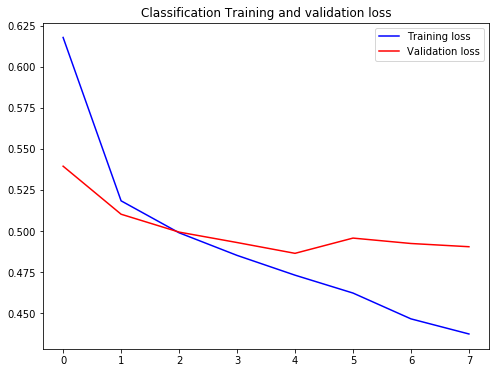

In [57]:
plot_train_history(model_history, 'Classification Training and validation loss')

In [22]:
model.load_weights(cur_file + '.h5')

preds = model.predict([x_val_multi, mean_scaled_val, std_scaled_val])
print(preds.shape, preds.max(), preds.min())

np.save(os.path.join(save_path, 'val_preds.npy'), preds)

### Model without normalized log(acc)

In [13]:
data_path = "../data/histStat_norm_class"

x_train_multi = np.load(os.path.join(data_path, "X_train_unnorm.npy"))
x_val_multi = np.load(os.path.join(data_path, "X_val_unnorm.npy"))

y_train_labels = np.load(os.path.join(data_path, "y_train_labels.npy"))
y_val_labels = np.load(os.path.join(data_path, "y_val_labels.npy"))

In [15]:
# ## Original Definition
from tensorflow.keras.layers import LSTM, Dense, concatenate, Input
from tensorflow.keras.models import Model

## Unnorm model
#Temporal sub-network for log(acc) 
tseries_in = Input(shape=x_train_multi.shape[1:])
tseries = LSTM(128, return_sequences=True, input_shape=x_train_multi.shape[1:], name='LSTM1')(tseries_in)
tseries = LSTM(64, return_sequences=True, activation='relu', name='LSTM2')(tseries)
tseries = LSTM(64, activation='relu', name='LSTM3')(tseries)
tseries = Dense(32, activation='relu', name='Dense_tseries')(tseries)
tseries = Dense(num_classes, activation='softmax', name='Dense_out')(tseries)

unnorm_model = Model(tseries_in, tseries, name="Unnorm_Quake_classifier")

unnorm_model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
unnorm_model.summary()

Model: "Unnorm_Quake_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 15)]          0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 15, 128)           73728     
_________________________________________________________________
LSTM2 (LSTM)                 (None, 15, 64)            49408     
_________________________________________________________________
LSTM3 (LSTM)                 (None, 64)                33024     
_________________________________________________________________
Dense_tseries (Dense)        (None, 32)                2080      
_________________________________________________________________
Dense_out (Dense)            (None, 6)                 198       
Total params: 158,438
Trainable params: 158,438
Non-trainable params: 0
_____________________________________

In [16]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from keras import optimizers

lr = .01
BATCH_SIZE=2048
save_path = "./trained_models_acc/classification"
if not os.path.exists(save_path):
    os.makedirs(save_path)
# cur_file = "LSTM3_10steps_dropzero"
cur_file = 'classifier_v1_unnorm'
cur_file = os.path.join(save_path, cur_file)

opt = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_check = ModelCheckpoint(cur_file + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                              save_weights_only=True, mode='min')
csv_log = CSVLogger(cur_file+ '_history.csv')
callback_list = [early_stop, reduce_lr, model_check, csv_log]


Using TensorFlow backend.


In [ ]:
EPOCHS = 50
unnorm_model_history = unnorm_model.fit(x_train_multi, 
                                          y_train_labels, 
                                          epochs=EPOCHS,
                                          validation_data=(x_val_multi, y_val_labels),
                                          class_weight = class_weights,
                                          batch_size = BATCH_SIZE, 
                                          callbacks=callback_list,
                                           shuffle=True
                                       )

Train on 999005 samples, validate on 249760 samples
Epoch 1/50
997376/999005 [============================>.] - ETA: 0s - loss: 0.8759 - accuracy: 0.5883
Epoch 00001: val_loss improved from inf to 0.70007, saving model to ./trained_models_acc/classification/classifier_v1_unnorm.h5
999005/999005 [==============================] - 122s 122us/sample - loss: 0.8756 - accuracy: 0.5884 - val_loss: 0.7001 - val_accuracy: 0.6878
Epoch 2/50
997376/999005 [============================>.] - ETA: 0s - loss: 0.7107 - accuracy: 0.6679
Epoch 00002: val_loss improved from 0.70007 to 0.63307, saving model to ./trained_models_acc/classification/classifier_v1_unnorm.h5
999005/999005 [==============================] - 117s 117us/sample - loss: 0.7106 - accuracy: 0.6680 - val_loss: 0.6331 - val_accuracy: 0.7213
Epoch 3/50
997376/999005 [============================>.] - ETA: 0s - loss: 0.6809 - accuracy: 0.6884
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00003: va

Epoch 23/50
997376/999005 [============================>.] - ETA: 0s - loss: 0.4770 - accuracy: 0.8054
Epoch 00023: val_loss improved from 0.48803 to 0.48676, saving model to ./trained_models_acc/classification/classifier_v1_unnorm.h5
999005/999005 [==============================] - 117s 117us/sample - loss: 0.4770 - accuracy: 0.8054 - val_loss: 0.4868 - val_accuracy: 0.8006
Epoch 24/50
997376/999005 [============================>.] - ETA: 0s - loss: 0.4767 - accuracy: 0.8055
Epoch 00024: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00024: val_loss did not improve from 0.48676
999005/999005 [==============================] - 117s 117us/sample - loss: 0.4767 - accuracy: 0.8055 - val_loss: 0.4873 - val_accuracy: 0.8001
Epoch 25/50
997376/999005 [============================>.] - ETA: 0s - loss: 0.4762 - accuracy: 0.8058
Epoch 00025: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00025: val_loss improved from 0.48676 to 0.48675, savi

In [17]:
unnorm_model.load_weights(cur_file + '.h5')

preds = unnorm_model.predict(x_val_multi)
print(preds.shape, preds.max(), preds.min())

np.save(os.path.join(save_path, 'val_preds_unnorm.npy'), preds)

(249760, 6) 1.0 7.657487e-35


## Model not trained on tseries data

In [25]:
data_path = "../data/histStat_norm_class"

y_train_labels = np.load(os.path.join(data_path, "y_train_labels.npy"))
y_val_labels = np.load(os.path.join(data_path, "y_val_labels.npy"))

train_mean = np.squeeze(np.load(os.path.join(data_path, "mean_train_histnorm.npy")))
train_std =  np.squeeze(np.load(os.path.join(data_path, "std_train_histnorm.npy")))

val_mean = np.squeeze(np.load(os.path.join(data_path, "mean_val_histnorm.npy")))
val_std =  np.squeeze(np.load(os.path.join(data_path, "std_val_histnorm.npy")))


mean_scaler = preprocessing.StandardScaler().fit(train_mean)
std_scaler = preprocessing.StandardScaler().fit(train_std)

# x_train_multi = X_scaler.transform(x_train_multi)
mean_scaled_train = mean_scaler.transform(train_mean)
std_scaled_train = std_scaler.transform(train_std)

# x_val_multi = X_scaler.transform(x_val_multi)
mean_scaled_val = mean_scaler.transform(val_mean)
std_scaled_val = std_scaler.transform(val_std)

In [29]:
# ## Original Definition
from tensorflow.keras.layers import LSTM, Dense, concatenate, Input
from tensorflow.keras.models import Model

size1_in = Input(train_mean.shape[1:])
size1 = Dense(16, activation='relu', name="Dense_mean")(size1_in)
# size_model1 = Model(size1_in, size1)

size2_in = Input(train_mean.shape[1:])
size2 = Dense(16, activation='relu', name="Dense_std")(size2_in)
# size_model2 = Model(size2_in, size2)

size_branches = concatenate([size1, size2])
size_branches = Dense(64, activation='relu', name="Dense_size")(size_branches)
size_branches = Dense(32, activation='relu', name="Dense_size_2")(size_branches)

out = Dense(num_classes, activation='softmax', name='merged_out')(size_branches)

model_nontemporal = Model(inputs = [size1_in, size2_in], outputs = [out], name="Nontemporal_Quake_classifier")


model_nontemporal.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
model_nontemporal.summary()

Model: "Nontemporal_Quake_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
Dense_mean (Dense)              (None, 16)           256         input_16[0][0]                   
__________________________________________________________________________________________________
Dense_std (Dense)               (None, 16)           256         input_17[0][0]                   
_______________________________________________________________________

In [27]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from keras import optimizers

lr = .01
BATCH_SIZE=2048
save_path = "./trained_models_acc/classification"
if not os.path.exists(save_path):
    os.makedirs(save_path)
# cur_file = "LSTM3_10steps_dropzero"
cur_file = 'classifier_v1_nontemporal'
cur_file = os.path.join(save_path, cur_file)

opt = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_check = ModelCheckpoint(cur_file + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                              save_weights_only=True, mode='min')
csv_log = CSVLogger(cur_file+ '_history.csv')
callback_list = [early_stop, reduce_lr, model_check, csv_log]


In [30]:
EPOCHS = 50
model_nontemporal_history = model_nontemporal.fit([mean_scaled_train, std_scaled_train], 
                                          y_train_labels, 
                                          epochs=EPOCHS,
                                          validation_data=([mean_scaled_val, std_scaled_val], y_val_labels),
                                          class_weight = class_weights,
                                          batch_size = BATCH_SIZE, 
                                          callbacks=callback_list,
                                           shuffle=True
                                       )

Train on 999005 samples, validate on 249760 samples
Epoch 1/50
993280/999005 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.7268
Epoch 00001: val_loss improved from inf to 0.57042, saving model to ./trained_models_acc/classification/classifier_v1_nontemporal.h5
999005/999005 [==============================] - 14s 14us/sample - loss: 0.6895 - accuracy: 0.7270 - val_loss: 0.5704 - val_accuracy: 0.7650
Epoch 2/50
991232/999005 [============================>.] - ETA: 0s - loss: 0.5585 - accuracy: 0.7714
Epoch 00002: val_loss improved from 0.57042 to 0.54332, saving model to ./trained_models_acc/classification/classifier_v1_nontemporal.h5
999005/999005 [==============================] - 10s 10us/sample - loss: 0.5583 - accuracy: 0.7715 - val_loss: 0.5433 - val_accuracy: 0.7762
Epoch 3/50
993280/999005 [============================>.] - ETA: 0s - loss: 0.5393 - accuracy: 0.7783
Epoch 00003: val_loss improved from 0.54332 to 0.53377, saving model to ./trained_models_a

993280/999005 [============================>.] - ETA: 0s - loss: 0.4998 - accuracy: 0.7939
Epoch 00022: val_loss improved from 0.50710 to 0.50698, saving model to ./trained_models_acc/classification/classifier_v1_nontemporal.h5
999005/999005 [==============================] - 10s 10us/sample - loss: 0.4998 - accuracy: 0.7939 - val_loss: 0.5070 - val_accuracy: 0.7912
Epoch 23/50
993280/999005 [============================>.] - ETA: 0s - loss: 0.4998 - accuracy: 0.7939
Epoch 00023: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00023: val_loss improved from 0.50698 to 0.50693, saving model to ./trained_models_acc/classification/classifier_v1_nontemporal.h5
999005/999005 [==============================] - 10s 10us/sample - loss: 0.4998 - accuracy: 0.7939 - val_loss: 0.5069 - val_accuracy: 0.7913
Epoch 24/50
993280/999005 [============================>.] - ETA: 0s - loss: 0.4998 - accuracy: 0.7939
Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.9531250

In [31]:
model_nontemporal.load_weights(cur_file + '.h5')

preds = model_nontemporal.predict([mean_scaled_val, std_scaled_val])
print(preds.shape, preds.max(), preds.min())

np.save(os.path.join(save_path, 'val_preds_nontemporal.npy'), preds)

(249760, 6) 0.998317 2.1381644e-10
